# Visualizing the Predictions of Binary Classifiers

In [1]:
# imports and setup
import numpy as np
from scipy.special import expit as logistic_sigmoid
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

import sklearn.metrics
import sklearn.linear_model
import sklearn.tree
import sklearn.neighbors

%matplotlib inline
np.set_printoptions(suppress=True, precision=2)
plt.style.use('seaborn') # pretty matplotlib plots

sns.set(font_scale=2)

## Define simple dataset of points in 2D space

In [2]:
def create_2d_dataset(N=100, noise_stddev=0.1, random_state=0):
    random_state = np.random.RandomState(int(random_state))

    mA_2 = np.asarray([1, 0])
    covA_22 = np.square(noise_stddev) * np.eye(2)
    
    mB_2 = np.asarray([0, 0])
    covB_22 = np.square(noise_stddev) * np.eye(2)

    mC_2 = np.asarray([0, 1])
    covC_22 = np.square(noise_stddev) * np.eye(2)

    # Draw data from 3 "Gaussian" blobs
    xA_N2 = random_state.multivariate_normal(mA_2, covA_22, size=N)
    xB_N2 = random_state.multivariate_normal(mB_2, covB_22, size=N)
    xC_N2 = random_state.multivariate_normal(mC_2, covC_22, size=N)

    x_N2 = np.vstack([xA_N2, xB_N2, xC_N2])
    y_N = np.hstack([np.ones(xA_N2.shape[0]), np.zeros(xB_N2.shape[0]), np.ones(xC_N2.shape[0])])
    
    return x_N2, y_N

## Create the dataset with 100 points per class

In [3]:
x_N2, y_N = create_2d_dataset(N=100, noise_stddev=0.3)

## Define function to plot data as scatterpoints in 2d

In [4]:
def plot_pretty_data_colored_by_labels(x_N2, y_N):
    plt.plot(x_N2[y_N==0,0], x_N2[y_N==0,1], color='r', marker='x', linestyle='', markersize=5, mew=2);
    plt.plot(x_N2[y_N==1,0], x_N2[y_N==1,1], color='b', marker='+', linestyle='', markersize=8, mew=2);

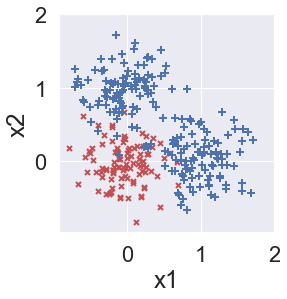

In [5]:
plot_pretty_data_colored_by_labels(x_N2, y_N);
plt.xlabel('x1');
plt.ylabel('x2');
plt.gca().set_aspect(1.0);
plt.xticks([0, 1, 2]);
plt.yticks([0, 1, 2]);

## Define function to make pretty plots of predicted probability color fields

In [6]:
def plot_pretty_probabilities_for_clf(
        clf,
        do_show_colorbar=False,
        x1_ticks=np.asarray([0, 2, 4]),
        x2_ticks=np.asarray([0, 2, 4]),
        c_levels=np.linspace(0, 1, 100),
        c_ticks=np.asarray([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
        x1_grid=np.linspace(-1, 2.3, 100),
        x2_grid=np.linspace(-1, 2.3, 100)):
    cur_ax = plt.gca()
    
    G = x1_grid.size
    H = x2_grid.size
    
    # Get regular grid of G x H points, where each point is an (x1, x2) location
    x1_GH, x2_GH = np.meshgrid(x1_grid, x2_grid)
    
    # Combine the x1 and x2 values into one array
    # Flattened into M = G x H rows
    # Each row of x_M2 is a 2D vector [x_m1, x_m2]
    x_M2 = np.hstack([x1_GH.flatten()[:,np.newaxis], x2_GH.flatten()[:,np.newaxis]])
    
    # Predict proba for each point in the flattened grid
    yproba1_M = clf.predict_proba(x_M2)[:,1]
    
    # Reshape the M probas into the GxH 2D field
    yproba1_GH = np.reshape(yproba1_M, x1_GH.shape)
    
    cmap = plt.cm.RdYlBu
    my_contourf_h = plt.contourf(x1_GH, x2_GH, yproba1_GH, levels=c_levels, vmin=0, vmax=1.0, cmap=cmap)
    
    plt.xticks(x1_ticks, x1_ticks);
    plt.yticks(x2_ticks, x2_ticks);
    
    if do_show_colorbar:
        left, bottom, width, height = plt.gca().get_position().bounds
        cax = plt.gcf().add_axes([left+1.1*width, bottom, 0.03, height])
        plt.colorbar(my_contourf_h, orientation='vertical', cax=cax, ticks=c_ticks);
        plt.sca(cur_ax);

# Define function to visualize hard decisions made as threshold

In [7]:
def plot_pretty_decision_boundaries_for_clf(
        clf,
        threshold=0.5,
        do_show_colorbar=False,
        x1_ticks=np.asarray([0, 2, 4]),
        x2_ticks=np.asarray([0, 2, 4]),
        c_levels=np.linspace(0, 1, 100),
        c_ticks=np.asarray([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
        x1_grid=np.linspace(-1, 2.3, 100),
        x2_grid=np.linspace(-1, 2.3, 100)):
    cur_ax = plt.gca()
    
    G = x1_grid.size
    H = x2_grid.size
    
    # Get regular grid of G x H points, where each point is an (x1, x2) location
    x1_GH, x2_GH = np.meshgrid(x1_grid, x2_grid)
    
    # Combine the x1 and x2 values into one array
    # Flattened into M = G x H rows
    # Each row of x_M2 is a 2D vector [x_m1, x_m2]
    x_M2 = np.hstack([x1_GH.flatten()[:,np.newaxis], x2_GH.flatten()[:,np.newaxis]])
    
    # Predict proba for each point in the flattened grid
    yproba1_M = clf.predict_proba(x_M2)[:,1]
    yhat_M = yproba1_M >= threshold
    
    # Reshape the M probas into the GxH 2D field
    yhat_GH = np.reshape(yhat_M, x1_GH.shape)
    
    cmap = plt.cm.RdYlBu
    my_contourf_h = plt.contourf(x1_GH, x2_GH, yhat_GH, levels=c_levels, vmin=0, vmax=1.0, cmap=cmap)
    
    plt.xticks(x1_ticks, x1_ticks);
    plt.yticks(x2_ticks, x2_ticks);
    
    if do_show_colorbar:
        left, bottom, width, height = plt.gca().get_position().bounds
        cax = plt.gcf().add_axes([left+1.1*width, bottom, 0.03, height])
        plt.colorbar(my_contourf_h, orientation='vertical', cax=cax, ticks=c_ticks);
        plt.sca(cur_ax);

## Decision Tree: predicted proba (colors) over 2D plane of (x1, x2)

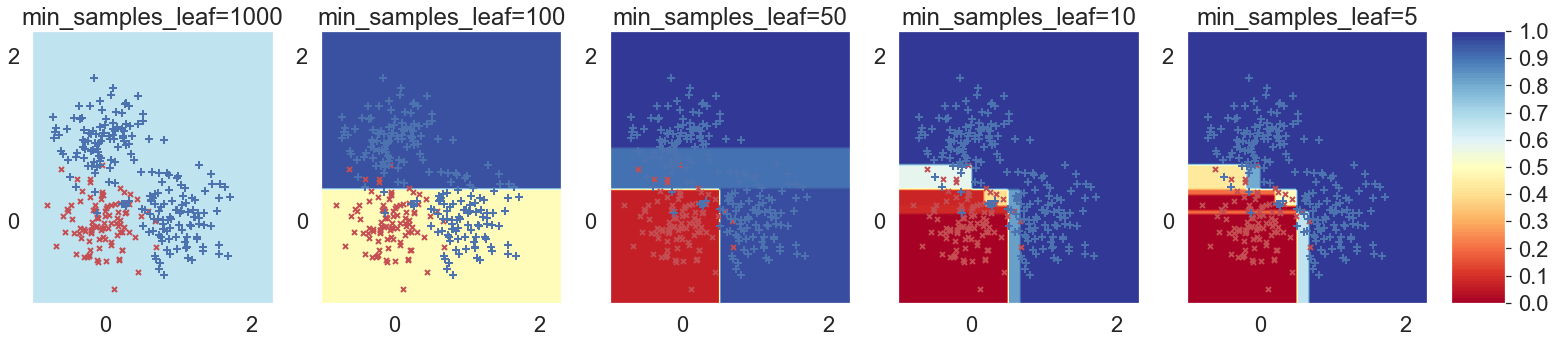

In [8]:
min_samples_leaf_grid = [1000, 100, 50, 10, 5]
ncols = len(min_samples_leaf_grid)

fig_h, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(5 * ncols, 5))

is_last = False
for ii, min_samples_leaf in enumerate(min_samples_leaf_grid):
    if ii == ncols - 1:
        is_last = True
    plt.sca(axes[ii])
    dtree = sklearn.tree.DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
    dtree.fit(x_N2, y_N)
    
    plot_pretty_probabilities_for_clf(dtree, do_show_colorbar=is_last);
    plot_pretty_data_colored_by_labels(x_N2, y_N);
    
    plt.title("min_samples_leaf=%d" % min_samples_leaf)

## Decision Tree: hard binary decisions (colors) over 2D plane of (x1, x2)

Using Threshold: 0.5

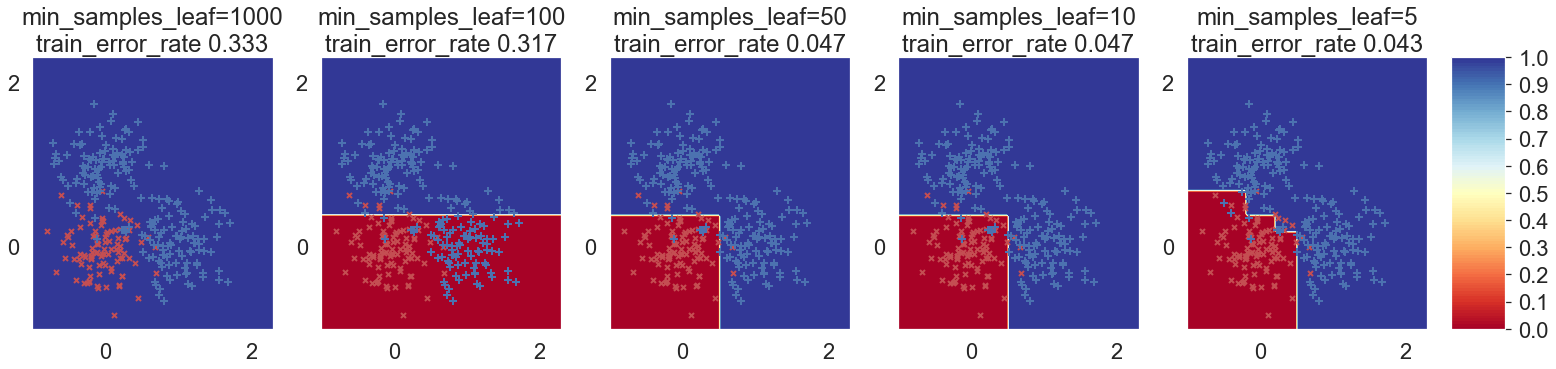

In [9]:
min_samples_leaf_grid = [1000, 100, 50, 10, 5]
ncols = len(min_samples_leaf_grid)

fig_h, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(5 * ncols, 5))

is_last = False
for ii, min_samples_leaf in enumerate(min_samples_leaf_grid):
    if ii == ncols - 1:
        is_last = True
    plt.sca(axes[ii])
    dtree = sklearn.tree.DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
    dtree.fit(x_N2, y_N)
    err_rate = np.mean(np.logical_xor(y_N, dtree.predict(x_N2)))
    
    plot_pretty_decision_boundaries_for_clf(dtree, do_show_colorbar=is_last);
    plot_pretty_data_colored_by_labels(x_N2, y_N);
    
    plt.title("min_samples_leaf=%d\ntrain_error_rate %.3f" % (min_samples_leaf, err_rate))

# KNN: predicted proba (colors) over 2D plane of x1, x2 

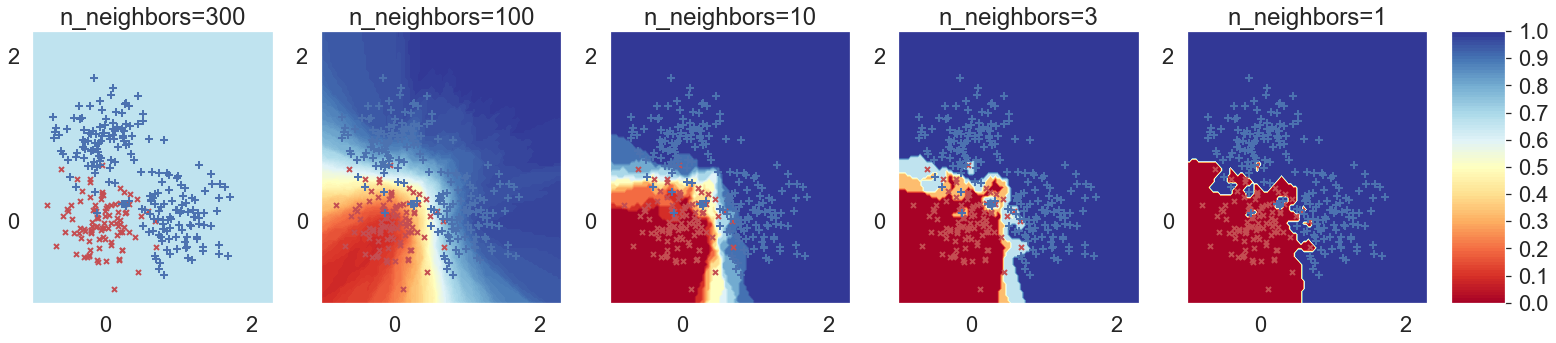

In [10]:
n_neighbors_grid = [y_N.size, 100, 10, 3,  1]
ncols = len(n_neighbors_grid)

fig_h, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(5 * ncols, 5))

is_last = False
for ii, n_neighbors in enumerate(n_neighbors_grid):
    if ii == ncols - 1:
        is_last = True
    plt.sca(axes[ii])
    clf = sklearn.neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, algorithm='brute')
    clf.fit(x_N2, y_N)
    
    plot_pretty_probabilities_for_clf(clf, do_show_colorbar=is_last);
    plot_pretty_data_colored_by_labels(x_N2, y_N);
    
    plt.title("n_neighbors=%d" % n_neighbors)

## KNN: hard binary decisions (colors) over 2D plane of (x1, x2)

Using Threshold: 0.5

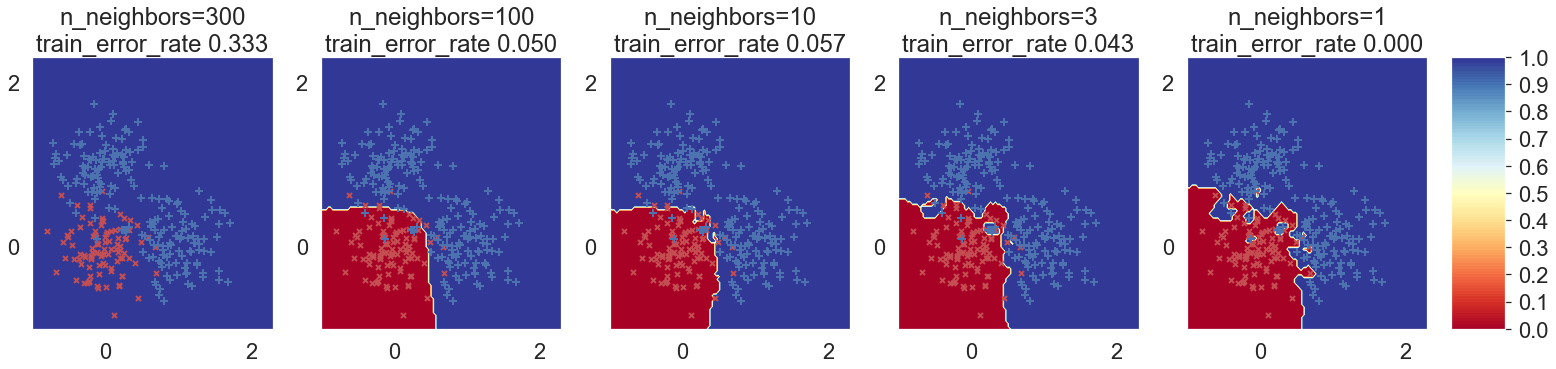

In [11]:
n_neighbors_grid = [y_N.size, 100, 10, 3,  1]
ncols = len(n_neighbors_grid)

fig_h, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(5 * ncols, 5))

is_last = False
for ii, n_neighbors in enumerate(n_neighbors_grid):
    if ii == ncols - 1:
        is_last = True
    plt.sca(axes[ii])
    clf = sklearn.neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, algorithm='brute')
    clf.fit(x_N2, y_N)
    err_rate = np.mean(np.logical_xor(y_N, clf.predict(x_N2)))
    
    plot_pretty_decision_boundaries_for_clf(clf, do_show_colorbar=is_last);
    plot_pretty_data_colored_by_labels(x_N2, y_N);
    
    plt.title("n_neighbors=%d\ntrain_error_rate %.3f" % (n_neighbors, err_rate))

# Show Logistic Regression predicted proba

[0.01 0.01 0.  ]
[0.35 0.37 0.19]
[ 3.64  4.03 -1.08]
[ 6.35  7.08 -2.22]
[ 6.45  7.19 -2.26]


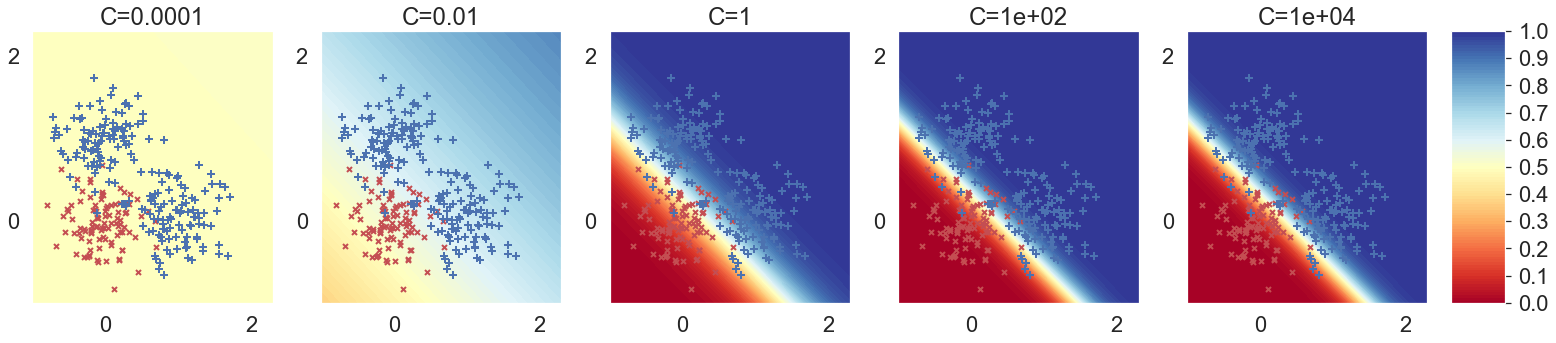

In [26]:
C_grid = np.asarray([0.0001, 0.01, 1, 100, 10000])
ncols = len(C_grid)

fig_h, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(5 * ncols, 5))

is_last = False
for ii, C in enumerate(C_grid):
    if ii == ncols - 1:
        is_last = True
    plt.sca(axes[ii])
    clf = sklearn.linear_model.LogisticRegression(C=C)
    clf.fit(x_N2, y_N)
    if ii == 0:
        clf0 = clf
    
    plot_pretty_probabilities_for_clf(clf, do_show_colorbar=is_last);
    plot_pretty_data_colored_by_labels(x_N2, y_N);
    
    plt.title("C=%.2g" % C)
    print(np.hstack([clf.coef_.flatten(), np.atleast_1d(clf.intercept_)]))

In [34]:
logistic_sigmoid(0.01 * -0.4 * 2)

0.4980000106665984

In [36]:
clf0.coef_[0]

array([0.01, 0.01])

In [35]:
clf0.predict_proba(np.asarray([[-.4, -.4]]))

array([[0.5, 0.5]])

## Decision Tree: hard binary decisions (colors) over 2D plane of (x1, x2)

Using Threshold: 0.5

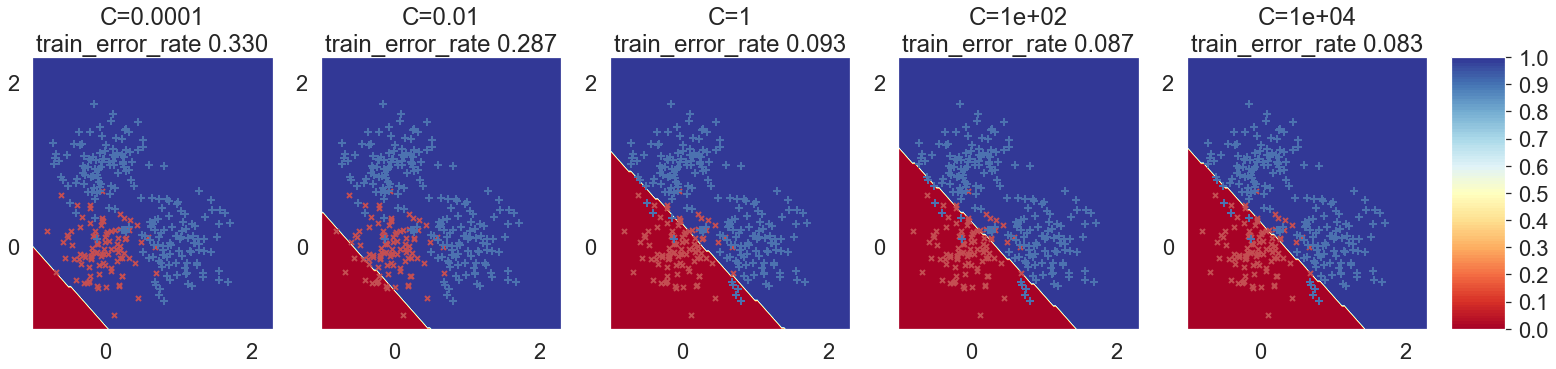

In [13]:
C_grid = np.asarray([0.0001, 0.01, 1, 100, 10000])
ncols = len(C_grid)

fig_h, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(5 * ncols, 5))

is_last = False
for ii, C in enumerate(C_grid):
    if ii == ncols - 1:
        is_last = True
    plt.sca(axes[ii])
    clf = sklearn.linear_model.LogisticRegression(C=C)
    clf.fit(x_N2, y_N)
    train_err_rate = np.mean(np.logical_xor(y_N, clf.predict(x_N2)))
    plot_pretty_decision_boundaries_for_clf(clf, 0.5, do_show_colorbar=is_last);
    plot_pretty_data_colored_by_labels(x_N2, y_N);
    
    plt.title("C=%.2g\ntrain_error_rate %.3f" % (C, train_err_rate))

## Show specific plots

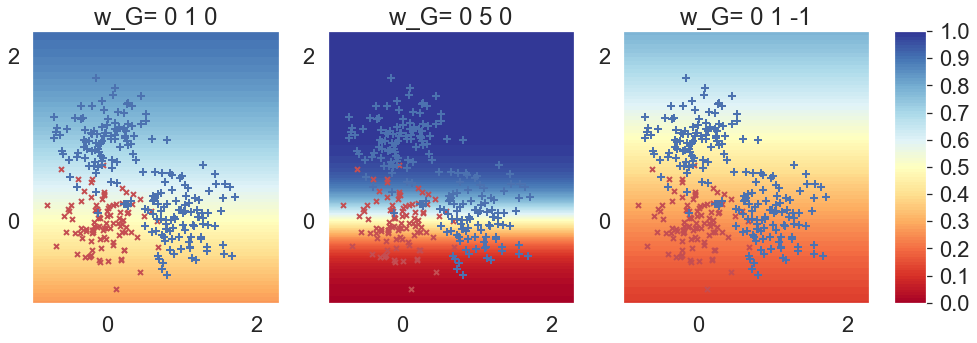

In [22]:
w_grid = [[0, 1, 0], [0 , 5, 0], [0, 1, -1]]
ncols = len(w_grid)

fig_h, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(5 * ncols, 5))

clf = sklearn.linear_model.LogisticRegression(C=10.0)
clf.fit(x_N2, y_N)

is_last = False
for ii, w_G in enumerate(w_grid):
    if ii == ncols - 1:
        is_last = True

    clf.coef_[:] = w_G[:-1]
    clf.intercept_ = w_G[-1]
        
    plt.sca(axes[ii])
    plot_pretty_probabilities_for_clf(clf, do_show_colorbar=is_last);
    plot_pretty_data_colored_by_labels(x_N2, y_N);
    
    plt.title("w_G= %s" % ' '.join(['%d' % wval for wval in w_G]))

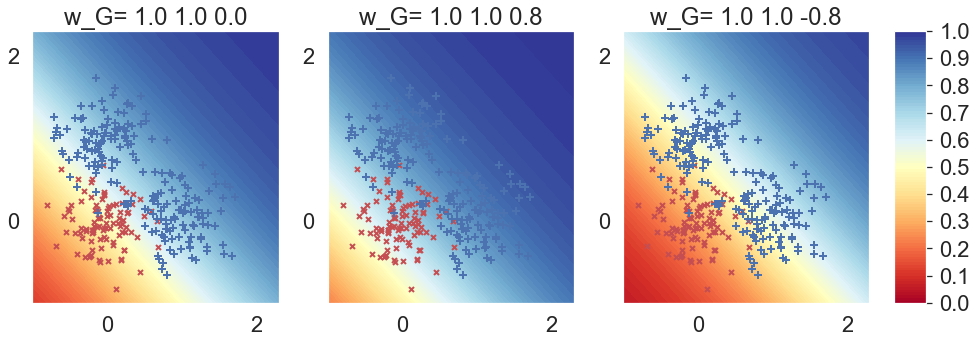

In [24]:
w_grid = [[1, 1, 0], [1, 1, +0.8], [1, 1, -0.8]]
ncols = len(w_grid)

fig_h, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(5 * ncols, 5))

clf = sklearn.linear_model.LogisticRegression(C=10.0)
clf.fit(x_N2, y_N)

is_last = False
for ii, w_G in enumerate(w_grid):
    if ii == ncols - 1:
        is_last = True

    clf.coef_[:] = w_G[:-1]
    clf.intercept_ = w_G[-1]
        
    plt.sca(axes[ii])
    plot_pretty_probabilities_for_clf(clf, do_show_colorbar=is_last);
    plot_pretty_data_colored_by_labels(x_N2, y_N);
    
    plt.title("w_G= %s" % ' '.join(['%.1f' % wval for wval in w_G]))